In [8]:
import cv2 as cv
from matplotlib import pyplot as plt


photos = ["IMG_0548.JPG",
          "IMG_0549.JPG",
          "IMG_0550.JPG",
          "IMG_1095.JPG",
          "IMG_1096.JPG",
          "IMG_1097.JPG",
          "IMG_1098.JPG",
          "IMG_1099.JPG",
        ]


for photo in photos:
    img = cv.imread(f"{photo}")
    # img = cv.cvtColor(img, cv.COLOR_BGR2RGB)




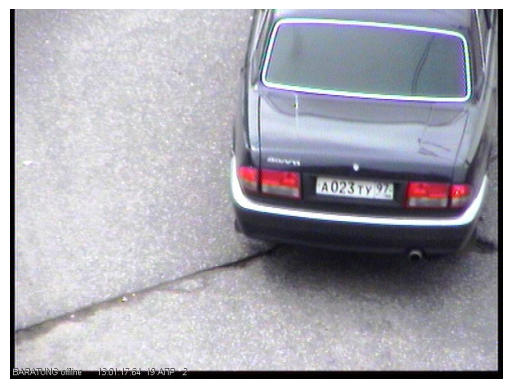

In [9]:
img = cv.imread(photos[0])
img = cv.cvtColor(img, cv.COLOR_BGR2RGB)  # Конвертируем BGR в RGB

plt.imshow(img)
plt.axis('off')
plt.show()

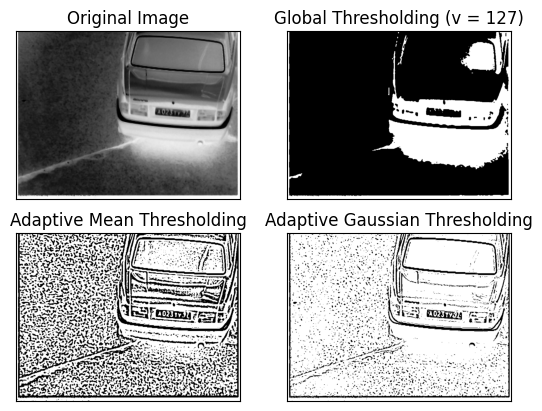

In [10]:
img = cv.imread(photos[0], cv.IMREAD_GRAYSCALE)
img = cv.bitwise_not(img)
# img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

assert img is not None, "file could not be read, check with os.path.exists()"
img = cv.medianBlur(img,5)

ret,th1 = cv.threshold(img,127,255,cv.THRESH_BINARY)

th2 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_MEAN_C,\
            cv.THRESH_BINARY,11,2)

th3 = cv.adaptiveThreshold(img,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv.THRESH_BINARY,11,4)

titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']

images = [img, th1, th2, th3]
for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

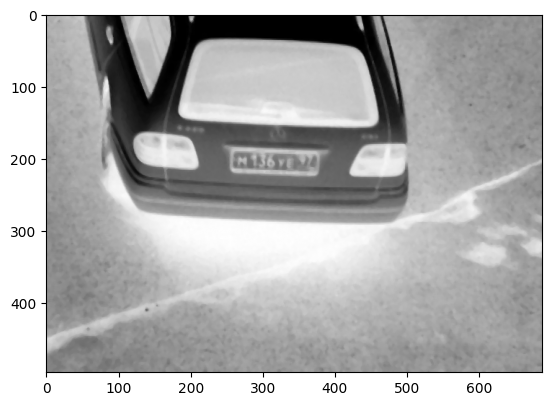

In [11]:
import numpy as np

orig = cv.imread(photos[7], cv.IMREAD_GRAYSCALE)
orig = cv.bitwise_not(orig)

# Обрезаем края изображения чтобы не видеть лишних контуров
crop_pixels = 40
orig = orig[crop_pixels:-crop_pixels, crop_pixels:-crop_pixels]

assert orig is not None, "file could not be read, check with os.path.exists()"

orig = cv.medianBlur(orig,5)



plt.imshow(orig,'gray')
plt.show()

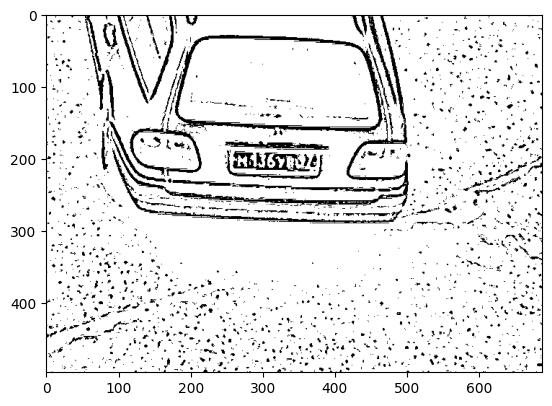

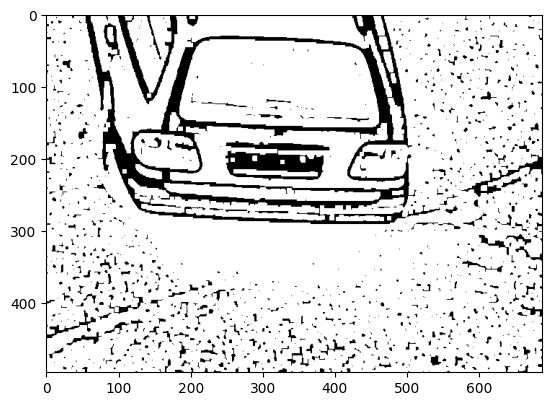

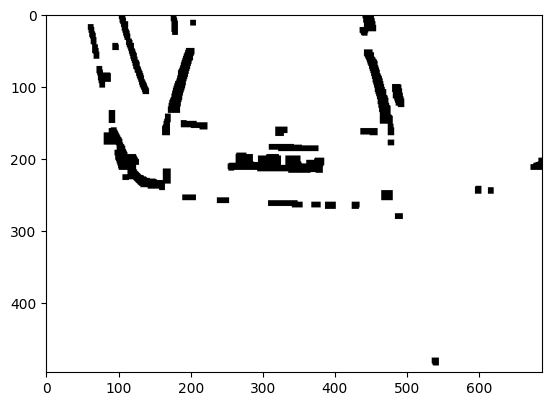

In [12]:
img = cv.adaptiveThreshold(orig,255,cv.ADAPTIVE_THRESH_GAUSSIAN_C, cv.THRESH_BINARY,11,4)
plt.imshow(img,'gray')
plt.show()

n = 6
kernel = np.ones((n,n), np.uint8)
morphed = cv.morphologyEx(img, cv.MORPH_OPEN, kernel)  # Закрытие - склеивает близкие белые области
plt.imshow(morphed,'gray')
plt.show()

n = 8
kernel = np.ones((n,n), np.uint8)
morphed = cv.morphologyEx(morphed, cv.MORPH_CLOSE, kernel)  # Закрытие - склеивает близкие белые области
plt.imshow(morphed,'gray')
plt.show()


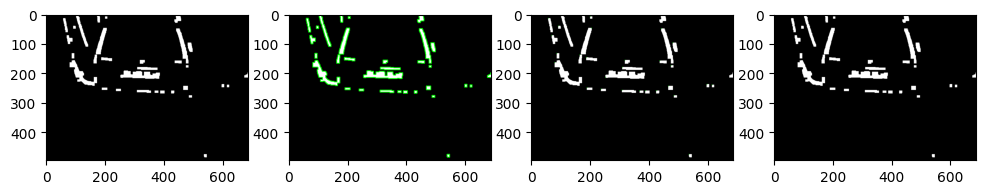

In [13]:
# Находим все контуры
img = cv.bitwise_not(morphed)
contours, hierarchy = cv.findContours(img, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Создаем копию исходного изображения для рисования
img_with_all_contours_1 = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.drawContours(img_with_all_contours_1, contours, -1, (0, 255, 0), 2)

approximated = []

for contour in contours:
    # Упрощаем контур до многоугольника
    epsilon = 0.05 * cv.arcLength(contour, True)
    approximated.append(cv.approxPolyDP(contour, epsilon, True))

# Создаем копию исходного изображения для рисования
img_with_all_contours_2 = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.drawContours(img_with_all_contours_2, approximated, -1, (0, 255, 0), 2)

plate_contours = []
for approx in approximated:
    x, y, w, h = cv.boundingRect(approx)
    aspect_ratio = w / h

    # Российский номер: 3:1 - 6:1 (с учетом перспективы)
    if 3.0 <= aspect_ratio <= 5.5 and len(approx) == 4:
        plate_contours.append(approx)



# Создаем копию исходного изображения для рисования
img_with_all_contours_3 = cv.cvtColor(img, cv.COLOR_GRAY2BGR)
cv.drawContours(img_with_all_contours_3, plate_contours, -1, (0, 255, 0), 2)

num_photos = 4

plt.figure(figsize=(12, 6))
plt.subplot(1, num_photos, 1)
plt.imshow(img, cmap='gray')
plt.subplot(1, num_photos, 2)
plt.imshow(cv.cvtColor(img_with_all_contours_1, cv.COLOR_BGR2RGB))
plt.subplot(1, num_photos, 3)
plt.imshow(cv.cvtColor(img_with_all_contours_2, cv.COLOR_BGR2RGB))
plt.subplot(1, num_photos, 4)
plt.imshow(cv.cvtColor(img_with_all_contours_3, cv.COLOR_BGR2RGB))
plt.show()

Прямоугольник не найден


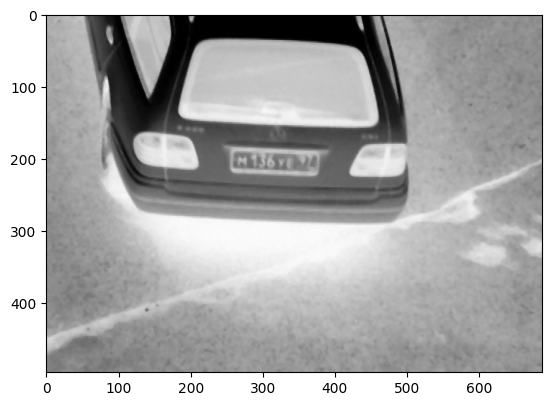

In [14]:
contours, _ = cv.findContours(morphed, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

best_rectangle = None
best_score = 0

for contour in contours:
    # Упрощаем контур до многоугольника
    epsilon = 0.02 * cv.arcLength(contour, True)
    approx = cv.approxPolyDP(contour, epsilon, True)

    # Нас интересуют только 4-угольники
    if len(approx) == 4:
        # Оцениваем "прямоугольность" по соотношению сторон
        x, y, w, h = cv.boundingRect(approx)
        aspect_ratio = max(w/h, h/w)
        # Идеальный прямоугольник имеет соотношение ~2-3 для номеров
        if 1.5 < aspect_ratio < 4:
            area_ratio = cv.contourArea(approx) / (w * h)
            # Чем ближе area_ratio к 1, тем более прямоугольный
            rectangle_score = 1 - abs(1 - area_ratio)
            if rectangle_score > best_score:
                best_score = rectangle_score
                best_rectangle = approx

# Визуализируем лучший прямоугольник
result = cv.cvtColor(orig, cv.COLOR_GRAY2BGR)
if best_rectangle is not None:
    cv.drawContours(result, [best_rectangle], -1, (0,255,0), 3)
    print(f"Найден прямоугольник с score: {best_score:.2f}")
else:
    print("Прямоугольник не найден")

plt.imshow(cv.cvtColor(result, cv.COLOR_BGR2RGB))
plt.show()